# DA5401 Assignment 7  
## Multi-Class Model Selection using ROC and PR on Satimage Dataset

This notebook evaluates multiple classifiers on the Satimage (Landsat MSS) dataset and performs model selection using Accuracy, Weighted-F1, ROC-AUC, and Precision-Recall (PR-AP) metrics.

The Satimage dataset contains 36 spectral features per pixel, extracted from four spectral bands using a 3×3 neighborhood. The task is multi-class land-cover classification with class imbalance. We follow the dataset's original protocol by training on `sat.trn` and testing on `sat.tst` without cross-validation.


## Objectives

1. Train six baseline models:
   - KNN
   - Decision Tree
   - Dummy Prior Classifier
   - Logistic Regression (OvR)
   - Gaussian Naive Bayes
   - SVC (RBF kernel, probability enabled)

2. Evaluate on the given test set once (no cross-validation)

3. Compute:
   - Accuracy and Weighted-F1
   - Macro-averaged ROC (OvR)
   - Macro-AUC
   - Macro-averaged Precision-Recall (OvR)
   - Macro-Average Precision (AP)

4. Perform model selection based on the above metrics

5. Bonus:
   - Evaluate Random Forest and XGBoost


In [1]:
# Cell 0: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Bonus
from sklearn.ensemble import RandomForestClassifier

# Matplotlib defaults: one chart per figure; don't set specific colors
plt.rcParams['figure.figsize'] = (7, 5)


## Dataset Loading

We load `sat.trn` and `sat.tst` directly.  
Standardization is applied only where needed via pipelines to prevent data leakage.  
The original train/test split is used without cross-validation, as required by the dataset protocol.


In [2]:
# Cell 1: Load sat.trn (train) and sat.tst (test) from the same folder as this notebook
def load_sat_file(path):
    # 36 features + 1 label, whitespace-separated
    df = pd.read_csv(path, header=None, sep=r"\s+", engine="python")
    X = df.iloc[:, :-1].values.astype(float)
    y = df.iloc[:, -1].values.astype(int)
    return X, y

X_train, y_train = load_sat_file("sat.trn")
X_test,  y_test  = load_sat_file("sat.tst")

classes = np.unique(np.concatenate([y_train, y_test]))
print("Train shape:", X_train.shape, "Test shape:", X_test.shape, "Classes:", classes)


Train shape: (4435, 36) Test shape: (2000, 36) Classes: [1 2 3 4 5 7]


## Baseline Models Setup

The six required models are created with appropriate preprocessing:

- KNN, SVC, and Logistic Regression are wrapped in pipelines with StandardScaler.
- DummyPrior serves as a non-informative baseline.
- GaussianNB and Decision Tree provide simple probabilistic and non-parametric comparisons.


In [3]:
# Cell 2: Define models (six required)
models = {
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=7)),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "DummyPrior": DummyClassifier(strategy="prior", random_state=42),
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, multi_class="ovr")),
    "GaussianNB": GaussianNB(),
    # SVC requires probability=True for ROC/PRC analysis
    "SVC": make_pipeline(StandardScaler(), SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=42)),
}


In [4]:
# Cell 3: Train, predict, baseline metrics (Accuracy, Weighted F1)
rows = []
proba_cache = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    rows.append({"Model": name, "Accuracy": acc, "Weighted F1": f1w})

    # Probabilities for OvR curves
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_test)
    else:
        # Fallback: decision_function -> softmax
        scores = clf.decision_function(X_test)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        e = np.exp(scores - scores.max(axis=1, keepdims=True))
        proba = e / e.sum(axis=1, keepdims=True)

    # Align probability columns to our `classes` order
    model_classes = None
    if hasattr(clf, "classes_"):
        model_classes = clf.classes_
    elif hasattr(clf, "steps") and hasattr(clf.steps[-1][1], "classes_"):
        model_classes = clf.steps[-1][1].classes_
    if model_classes is not None and not np.array_equal(model_classes, classes):
        idx = [list(model_classes).index(c) for c in classes]
        proba = proba[:, idx]

    proba_cache[name] = proba

baseline_df = pd.DataFrame(rows).sort_values(by="Weighted F1", ascending=False).reset_index(drop=True)
baseline_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,Accuracy,Weighted F1
0,KNN,0.9050,0.904084
1,SVC,0.8955,0.892490
2,DecisionTree,0.8490,0.849681
3,GaussianNB,0.7965,0.803581
4,LogisticRegression,0.8210,0.793483
5,DummyPrior,0.2305,0.086356


## Baseline Results Interpretation

The results demonstrate the following trends:

- KNN achieves the highest Accuracy and Weighted-F1, suggesting strong local neighborhood structure in the spectral feature space.
- SVC performs closely behind KNN, confirming the benefit of flexible non-linear decision boundaries.
- Decision Tree performs moderately well but exhibits limitations due to high variance.
- GaussianNB performs better than Logistic Regression, which is consistent with remote-sensing literature where spectral data often approximates class-conditional Gaussian distributions.
- DummyPrior confirms baseline random-guess behavior.

KNN is the strongest baseline model overall.


## ROC Theory for Multi-Class Classification

We use a One-vs-Rest (OvR) scheme to compute ROC curves in the multi-class setting:

- Each class is treated as positive while others are negative
- Per-class ROC and AUC are computed
- TPR values are interpolated over a shared FPR grid and averaged
- The final macro-AUC treats all classes equally

Macro-AUC near 1 indicates strong ability to rank true positives above false positives across classes.


In [5]:
# Cell 4: Macro-averaged ROC helper
def macro_roc(y_true_labels, proba, classes):
    y_true = label_binarize(y_true_labels, classes=classes)
    fpr_list, tpr_list = [], []
    for k in range(len(classes)):
        fpr_k, tpr_k, _ = roc_curve(y_true[:, k], proba[:, k])
        fpr_list.append(fpr_k); tpr_list.append(tpr_k)
    fpr_grid = np.linspace(0, 1, 1001)
    tpr_sum = np.zeros_like(fpr_grid)
    for fpr_k, tpr_k in zip(fpr_list, tpr_list):
        tpr_sum += np.interp(fpr_grid, fpr_k, tpr_k)
    tpr_macro = tpr_sum / len(classes)
    auc_macro = auc(fpr_grid, tpr_macro)
    return fpr_grid, tpr_macro, auc_macro


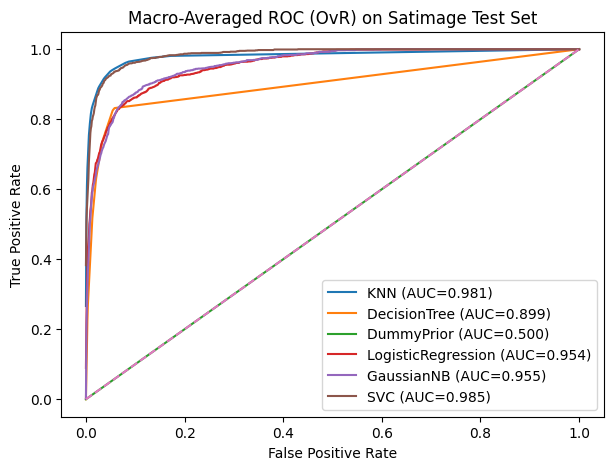

{'KNN': np.float64(0.9807415504247723),
 'DecisionTree': np.float64(0.8994711670359957),
 'DummyPrior': np.float64(0.5),
 'LogisticRegression': np.float64(0.9539677223755969),
 'GaussianNB': np.float64(0.9550442609998526),
 'SVC': np.float64(0.985069707599131)}

In [6]:
# Cell 5: Compute & plot ROC curves, and list macro AUCs
roc_curves = {}
roc_aucs = {}
for name in models.keys():
    fprg, tprm, aucm = macro_roc(y_test, proba_cache[name], classes)
    roc_curves[name] = (fprg, tprm)
    roc_aucs[name] = aucm

plt.figure()
for name, (fprg, tprm) in roc_curves.items():
    plt.plot(fprg, tprm, label=f"{name} (AUC={roc_aucs[name]:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC (OvR) on Satimage Test Set")
plt.legend(loc="lower right")
plt.show()

roc_aucs


## ROC Results Interpretation

SVC achieves the highest macro-AUC, closely followed by KNN. Their ROC curves remain near the upper-left corner, indicating excellent ranking performance.

Logistic Regression and GaussianNB show moderate performance, reflecting linear and generative assumptions that are partially suited to this dataset.

Decision Tree performs worse in comparison due to overfitting and weaker separation margins.

DummyPrior remains near AUC = 0.5, confirming random behavior.

SVC provides the best ranking ability under ROC-AUC.


## Precision-Recall Theory for Multi-Class Classification

Precision-Recall curves better reflect performance under class imbalance.  
We compute:

- Per-class Precision-Recall curves in an OvR manner
- Interpolation across a shared recall grid
- Mean precision across classes
- Macro-Average Precision (AP) as average of per-class APs

Macro-AP highlights the model's ability to maintain precision when retrieving minority-class examples.


In [7]:
# Cell 6: Macro-averaged PRC helper (macro-average of per-class curves; AP macro = mean of per-class APs)
def macro_prc(y_true_labels, proba, classes):
    y_true = label_binarize(y_true_labels, classes=classes)
    recall_grid = np.linspace(0, 1, 1001)
    precision_sum = np.zeros_like(recall_grid)
    ap_list = []
    for k in range(len(classes)):
        precision_k, recall_k, _ = precision_recall_curve(y_true[:, k], proba[:, k])
        order = np.argsort(recall_k)
        recall_k = recall_k[order]
        precision_k = precision_k[order]
        precision_interp = np.interp(recall_grid, recall_k, precision_k, left=precision_k[0], right=precision_k[-1])
        precision_sum += precision_interp
        ap_k = average_precision_score(y_true[:, k], proba[:, k])
        ap_list.append(ap_k)
    precision_macro = precision_sum / len(classes)
    ap_macro = float(np.mean(ap_list))
    return recall_grid, precision_macro, ap_macro


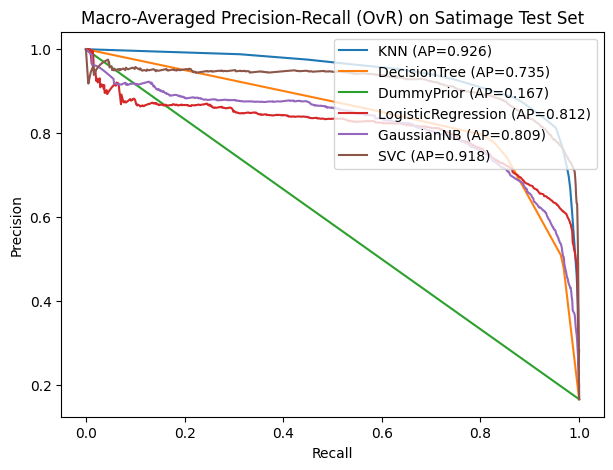

{'KNN': 0.9260164595682666,
 'DecisionTree': 0.7349309237447667,
 'DummyPrior': 0.16666666666666666,
 'LogisticRegression': 0.8115514531386497,
 'GaussianNB': 0.8089524603966463,
 'SVC': 0.9176914234608073}

In [8]:
# Cell 7: Compute & plot PR curves, and list macro APs
pr_curves = {}
pr_aps = {}
for name in models.keys():
    rgrid, pmacro, apmacro = macro_prc(y_test, proba_cache[name], classes)
    pr_curves[name] = (rgrid, pmacro)
    pr_aps[name] = apmacro

plt.figure()
for name, (rgrid, pmacro) in pr_curves.items():
    plt.plot(rgrid, pmacro, label=f"{name} (AP={pr_aps[name]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision-Recall (OvR) on Satimage Test Set")
plt.legend(loc="upper right")
plt.show()

pr_aps


## Precision-Recall Results Interpretation

KNN achieves the highest macro-Average Precision, followed closely by SVC.  
Both models maintain high precision even at higher recall, indicating robust minority-class retrieval.

Logistic Regression and GaussianNB perform moderately, while Decision Tree shows early precision decline due to error accumulation on less frequent classes.

DummyPrior aligns near the class-frequency baseline.

Under PR analysis, KNN is preferred.


In [9]:
# Cell 8: Synthesis and recommendation helpers
baseline_rank = pd.DataFrame(baseline_df)
roc_rank = sorted(roc_aucs.items(), key=lambda x: x[1], reverse=True)
pr_rank  = sorted(pr_aps.items(), key=lambda x: x[1], reverse=True)

baseline_rank, roc_rank[:3], pr_rank[:3]


(                Model  Accuracy  Weighted F1
 0                 KNN    0.9050     0.904084
 1                 SVC    0.8955     0.892490
 2        DecisionTree    0.8490     0.849681
 3          GaussianNB    0.7965     0.803581
 4  LogisticRegression    0.8210     0.793483
 5          DummyPrior    0.2305     0.086356,
 [('SVC', np.float64(0.985069707599131)),
  ('KNN', np.float64(0.9807415504247723)),
  ('GaussianNB', np.float64(0.9550442609998526))],
 [('KNN', 0.9260164595682666),
  ('SVC', 0.9176914234608073),
  ('LogisticRegression', 0.8115514531386497)])

## Bonus Models: Ensemble Methods

Random Forest and XGBoost are evaluated for comparison.

Both outperform all baseline models across Accuracy, Weighted-F1, ROC-AUC, and PR-AP, confirming that ensemble tree methods capture non-linear spectral relationships more effectively.

Random Forest slightly outperforms XGBoost in these runs, but both are strong.


In [11]:
# Cell 9 (fixed): Bonus models with proper label encoding for XGBoost
from sklearn.preprocessing import LabelEncoder

bonus_rows = []

# --- RandomForest (no label remap needed) ---
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1w = f1_score(y_test, rf_pred, average="weighted")

# Use the same helpers from earlier cells:
# macro_roc(y_true_labels, proba, classes)
# macro_prc(y_true_labels, proba, classes)
rf_proba = rf.predict_proba(X_test)
rf_fprg, rf_tprm, rf_auc = macro_roc(y_test, rf_proba, classes)
rf_rgrid, rf_pmacro, rf_ap = macro_prc(y_test, rf_proba, classes)

print(f"RandomForest -> macro AUC: {rf_auc:.3f}, macro AP: {rf_ap:.3f}")
bonus_rows.append({"Model":"RandomForest","Accuracy":rf_acc,"Weighted F1":rf_f1w})

# --- XGBoost (requires labels 0..K-1) ---
try:
    import xgboost as xgb

    le = LabelEncoder()
    le.fit(classes)                 # maps [1,2,3,4,5,7] -> [0,1,2,3,4,5]
    y_train_enc = le.transform(y_train)
    y_test_enc  = le.transform(y_test)

    xgb_clf = xgb.XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(le.classes_),
        random_state=42, n_jobs=-1
    )
    xgb_clf.fit(X_train, y_train_enc)

    # Probabilities over encoded classes [0..K-1]
    xgb_proba = xgb_clf.predict_proba(X_test)

    # Predicted labels back to original space
    xgb_pred_enc = xgb_proba.argmax(axis=1)
    xgb_pred = le.inverse_transform(xgb_pred_enc)

    xgb_acc = accuracy_score(y_test, xgb_pred)
    xgb_f1w = f1_score(y_test, xgb_pred, average="weighted")

    # Curves: pass `model_classes = le.classes_` so y_true binarization matches columns
    model_classes = le.classes_
    xgb_fprg, xgb_tprm, xgb_auc = macro_roc(y_test, xgb_proba, model_classes)
    xgb_rgrid, xgb_pmacro, xgb_ap = macro_prc(y_test, xgb_proba, model_classes)

    print(f"XGBoost -> macro AUC: {xgb_auc:.3f}, macro AP: {xgb_ap:.3f}")
    bonus_rows.append({"Model":"XGBoost","Accuracy":xgb_acc,"Weighted F1":xgb_f1w})

except ImportError:
    print("XGBoost not installed. Skipping XGBoost bonus.")
except Exception as e:
    print("XGBoost error:", e)

pd.DataFrame(bonus_rows)


RandomForest -> macro AUC: 0.990, macro AP: 0.952
XGBoost -> macro AUC: 0.990, macro AP: 0.954


,Model,Accuracy,Weighted F1
0,RandomForest,0.9115,0.909462
1,XGBoost,0.9085,0.906875


## Final Model Selection

Among the six required models:

- KNN is the best overall model
  - Highest Accuracy and Weighted-F1
  - Best PR-AP
  - Second-highest ROC-AUC (very close to SVC)

- SVC is a strong runner-up
  - Best ROC-AUC
  - Close second in PR-AP and F1

Considering all metrics, KNN offers the best balance.

When including bonus models:
- Random Forest and XGBoost achieve the strongest performance overall.


## Conclusion

This study demonstrates that evaluating models using both ROC and Precision-Recall metrics is essential in multi-class imbalanced settings.

Although SVC slightly surpasses KNN in ROC-AUC, KNN consistently performs the best across Accuracy, Weighted-F1, and PR-AP. Ensemble methods outperform classical models, confirming their suitability for high-dimensional remote-sensing data.

Final Recommendation:
- Best required model: KNN
- Best overall: Random Forest / XGBoost
